# Quantum Efficiency Analysis Workbook

Import Dependencies

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import scipy
from integrating_sphere_funcs import sphere_flux_correction
global c
c = 2.998 * 10 ** 10 # speed of light in cm/s
global h
h = 6.626 * 10 ** -27 # Planck's constant in g cm^2/s
this_dir = os.getcwd()

Create a class representing a calibrated photodiode with its associated response curve.

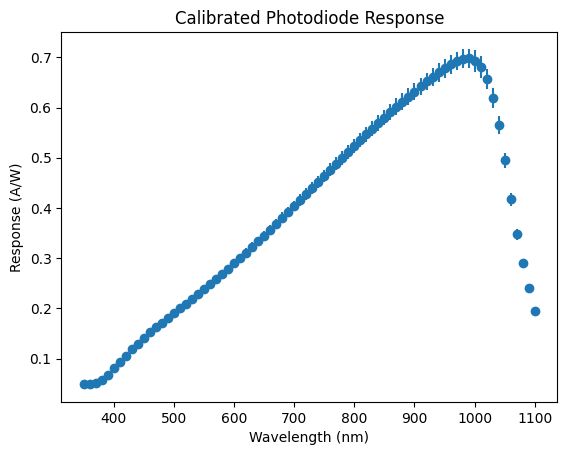

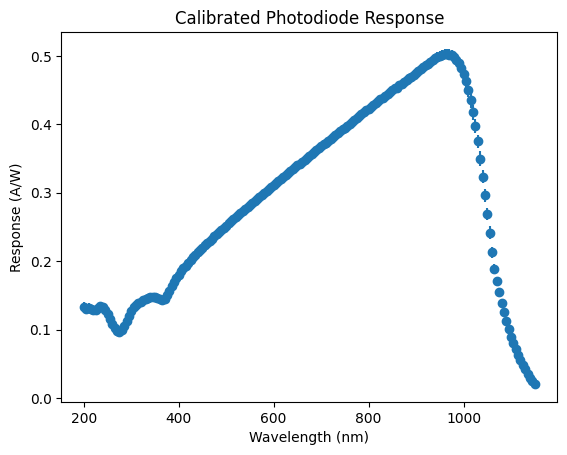

In [2]:
class CalibratedPD(object):
    '''A class to represent a calibrated photodiode.
    
    Attributes:
    ------------
    filename : str
        The complete path to the FITS or csv file containing the calibrated
        photodiode response. The data should have three columns:
        wavelength (nm), response (A/W), and uncertainty in response
        (percent).
    response : numpy.ndarray
        The calibrated photodiode response. First column is
        wavelength in nm, second column is response in A/W. Third
        column is uncertainty in response, in percent.
    area : float
        The area of the photodiode active area, in cm^2.
    plot : bool
        If True, a plot of the response will be generated.
    '''
    def __init__(self, filename, area, plot=False):
        if filename.endswith('.fits'):
            self.response = fits.getdata(filename)
        elif filename.endswith('.csv'):
            self.response = np.genfromtxt(filename, delimiter=',')
        self.area = area
        self.plot = plot
        if plot:
            self.plot_response()

    def plot_response(self):
        '''Plot the calibrated photodiode response.'''
        fig, ax = plt.subplots()
        errors = self.response[:,2] * self.response[:,1] / 100
        ax.errorbar(self.response[:,0], self.response[:,1],
                    yerr=errors, fmt='o')
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Response (A/W)')
        ax.set_title('Calibrated Photodiode Response')
        plt.show()

    def get_response(self, wavelength):
        '''Returns the calibrated photodiode response at a given wavelength.'''
        response = np.interp(wavelength, self.response[:,0], self.response[:,1])
        return response
    
data_dir = this_dir + '/data/'
thorlabs_filename = os.path.join(data_dir, 'ThorLabsPD.csv')
hamamatsu_filenmae = os.path.join(data_dir, 'HamamatsuPD.csv')
thorlabs_pd = CalibratedPD(thorlabs_filename, 1, plot=True)
hamamatsu_pd = CalibratedPD(hamamatsu_filenmae, 1, plot=True)

Create a class to input data from exposures at different wavelengths and calculate the QE. It also includes a method to estimate the depletion depth.

In [3]:
class QECalc(object):

    def __init__(self, wavelengths, exp_times, pd_dark_vals, pd_gray_vals,
                 img_dark_vals, img_gray_vals, pix_area, gain, pd,
                 pd_pos=np.array([1,1]), sensor_pos=np.array([1,1]), sensor_size=0,
                 int_sphere_port=4):
        '''Initializes the QECalc object with the necessary data to calculate the QE of the camera.

        Parameters:
        ----------
        wavelengths : numpy.ndarray
            The wavelength for each exposure, in nm.
        exp_times : numpy.ndarray
            The exposure time for each wavelength value, in s. For each wavelength value,
            two exposures are taken at the corresponding exposure time: one with the
            shutter closed and one with the shutter open.
        pd_dark_vals : numpy.ndarray
            The average current measured by the calibrated photodiode for each exposure
            with the shutter closed, in A.
        pd_gray_vals : numpy.ndarray
            The average current measured by the calibrated photodiode for each exposure
            with the shutter open, in A.
        img_dark_vals : numpy.ndarray
            The average pixel value for each exposure with the shutter closed.
        img_gray_vals : numpy.ndarray
            The average pixel value for each exposure with the shutter open.
        pix_area : float
            The area of each pixel in the camera, in cm^2.
        gain : float
            The gain of the camera, in ADU/e-.
        pd: CalibratedPD object
            The calibrated photodiode object used to calculate photon flux.
        pd_pos : numpy.ndarray (optional, default=[1,1])
            The position of the photodiode relative to the integrating sphere port.
            First entry is r, second entry is d. Units must be consistent with
            sensor_pos, sensor_size, and int_sphere_port.
        sensor_pos : numpy.ndarray (optional, default=[1,1])
            The position of the camera sensor relative to the integrating sphere port.
            First entry is r, second entry is d.
        sensor_size : float (optional, default=0)
            The width of the camera sensor. Assumes sensor is square.
        int_sphere_port : int (optional, default=4)
            The diameter of the integrating sphere port.
        '''
        self.wavelengths = wavelengths
        self.exp_times = exp_times
        self.pd_dark_vals = pd_dark_vals
        self.pd_gray_vals = pd_gray_vals
        self.img_dark_vals = img_dark_vals
        self.img_gray_vals = img_gray_vals
        self.pix_area = pix_area
        self.gain = gain
        self.pd = pd
        self.pd_pos = pd_pos
        self.sensor_pos = sensor_pos
        self.sensor_size = sensor_size
        self.int_sphere_port = int_sphere_port
        self.flux_corr = self.get_flux_correction()
        self.qe_vals = self.get_qe_vals()
        # self.depl_depth = self.get_depl_depth()

    def add_points(self, wavelengths, exp_times, pd_dark_vals, pd_gray_vals,
                    img_dark_vals, img_gray_vals):
        '''Adds additional data points to the QECalc object.'''
        self.wavelengths = np.append(self.wavelengths, wavelengths)
        self.exp_times = np.append(self.exp_times, exp_times)
        self.pd_dark_vals = np.append(self.pd_dark_vals, pd_dark_vals)
        self.pd_gray_vals = np.append(self.pd_gray_vals, pd_gray_vals)
        self.img_dark_vals = np.append(self.img_dark_vals, img_dark_vals)
        self.img_gray_vals = np.append(self.img_gray_vals, img_gray_vals)
        self.qe_vals = self.get_qe_vals()
        # self.depl_depth = self.get_depl_depth()

    def add_qe_points(self, wavelengths, qe_vals):
        '''Adds additional QE data points to the QECalc object.'''
        self.wavelengths = np.append(self.wavelengths, wavelengths)
        self.qe_vals = np.append(self.qe_vals, qe_vals)
        self.exp_times = np.append(self.exp_times, np.zeros_like(wavelengths) * np.NaN)
        self.pd_dark_vals = np.append(self.pd_dark_vals, np.zeros_like(wavelengths) * np.NaN)
        self.pd_gray_vals = np.append(self.pd_gray_vals, np.zeros_like(wavelengths) * np.NaN)
        self.img_dark_vals = np.append(self.img_dark_vals, np.zeros_like(wavelengths) * np.NaN)
        self.img_gray_vals = np.append(self.img_gray_vals, np.zeros_like(wavelengths) * np.NaN)
        # self.depl_depth = self.get_depl_depth()

    def get_flux_correction(self):
        '''Find correction factor for PD and sensor being at different positions relative to sphere.'''
        flux_corr = sphere_flux_correction(self.int_sphere_port, self.pd_pos[0], self.pd_pos[1],
                                           self.sensor_pos[0], self.sensor_pos[1], self.sensor_size)
        return flux_corr

    def get_qe_vals(self):
        '''Calculates the quantum efficiencies of the camera at each wavelength.'''
        qe_vals = np.zeros_like(self.pd_dark_vals)
        for i, wavelength in enumerate(self.wavelengths):
            pd_response = self.pd.get_response(wavelength)
            # Get the photon energy rate, in ergs/s
            phot_energy_rate = (self.pd_gray_vals[i] - self.pd_dark_vals[i]) / pd_response * 10 ** 7
            phot_energy = h * c / (wavelength * 10 ** -7)
            # Get the absolute photon flux, in phot/s/cm^2
            abs_phot_flux = phot_energy_rate / phot_energy / self.pd.area * self.flux_corr
            # Get the number of photons collected at the sensor per pixel per second
            img_phot_pix = (self.img_gray_vals[i] - self.img_dark_vals[i]) / self.gain / self.exp_times[i]
            qe_vals[i] = img_phot_pix / self.pix_area / abs_phot_flux
        return qe_vals
    
    def interp_qe(self, wavelength):
        '''Interpolates the quantum efficiency of the camera at a given wavelength.'''
        qe = np.interp(wavelength, self.wavelengths, self.qe_vals)
        return qe
    
    def get_depl_depth(self):
        '''Estimates the sensor depletion depth by fitting to silicon absorption.'''
        dir = os.path.abspath('')
        silicon_abs = np.genfromtxt(dir + '/data/silicon_absorption.csv', delimiter=',')
        def theoretical_qe(wavelength, depletion_depth, max_qe=1):
            '''Returns the theoretical quantum efficiency of silicon at a given wavelength'''
            abs_length = np.interp(wavelength, silicon_abs[:, 0], silicon_abs[:, 1])
            return (1 - np.exp(-depletion_depth / abs_length)) * max_qe
        fit_cut_on_wavelength = 600
        wavelength_arr = self.wavelengths[self.wavelengths > fit_cut_on_wavelength]
        qe_arr = self.qe_vals[self.wavelengths > fit_cut_on_wavelength]
        if len(wavelength_arr) < 5:
            raise ValueError('Not enough data points >600 nm to fit to silicon absorption.')
        popt, pcov = scipy.optimize.curve_fit(theoretical_qe, wavelength_arr, qe_arr, p0=[10, 1])
        return popt
    
    def plot_qe(self):
        '''Plots the quantum efficiency of the camera as a function of wavelength.'''
        plt.scatter(self.wavelengths, self.qe_vals)
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Quantum Efficiency')
        plt.ylim(0, 1)
        plt.show()


Dictionary relating filter number to wavelength

In [4]:
filter_dict = {'1A': 640, '2A': 700, '3A': 750, '4A': 800, '5A': 830, '6A': 850, '7A': 880, '8A': 905,
               '9A': 950, '10A': 980, '11A': 1000, '12A': 1064, '1B': 200, '2B': 250, '3B': 297,
                '4B': 350, '5B': 400, '6B': 450, '7B': 500, '8B': 550, '9B': 600, '10B': 440}